# Probabilistic PCA Tutorial
This tutorial will demonstrate Probabilistic PCA, a  factor analysis technique. 

Maths and notation following [Machine Learning: A Probabilistic Perspective](https://www.amazon.com/gp/product/0262018020).

## Installation
Follow the instrallation instructions in the [README](../../README.md) file to get setup.

```
# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
#   Licensed under the Apache License, Version 2.0 (the "License").
#   You may not use this file except in compliance with the License.
#   A copy of the License is located at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
#   or in the "license" file accompanying this file. This file is distributed
#   on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
#   express or implied. See the License for the specific language governing
#   permissions and limitations under the License.
# ==============================================================================
```


## Probabalistic Modeling Introduction

Probabilistic Models can be
categorized into directed graphical models (DGM, Bayes Net) and undirected
graphical models (UGM). Most popular probabilistic models
are DGMs, so MXFusion will only support the definition of
DGMs unless there is a strong customer need of UGMs in future.

A DGM can be fully defined using 3 basic components: deterministic functions,
probabilistic distributions, and random variables. We show the interface for
defining a model using each of the three components below.

First lets import the basic libraries we'll need to train our model and visualize some data.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import mxfusion as mf
import mxnet as mx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data Generation
We'll take as our function to learn components of the [log spiral function](https://en.wikipedia.org/wiki/Logarithmic_spiral) because it's 2-dimensional and easy to visualize.

In [2]:
def log_spiral(a,b,t):
    x = a * np.exp(b*t) * np.cos(t)
    y = a * np.exp(b*t) * np.sin(t)
    return np.vstack([x,y]).T

We parameterize the function with 100 data points and plot the resulting function.

In [3]:
N = 100
D = 100
K = 2

a = 1
b = 0.1
t = np.linspace(0,6*np.pi,N)
r = log_spiral(a,b,t)

In [4]:
r.shape

(100, 2)

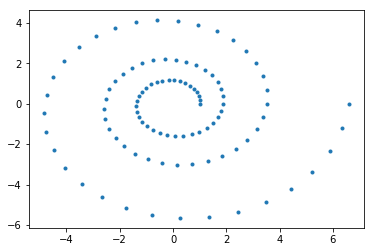

In [5]:
plt.plot(r[:,0], r[:,1],'.')

We now project our $K$ dimensional ```r``` into a high-dimensional $D$ space using a random matrix of random weights $W$. Now that ```r``` is embedded in a $D$ dimensional space the goal of PPCA will be to recover ```r``` in it's original low-dimensional $K$ space.

In [6]:
w = np.random.randn(K,N)
x_train = np.dot(r,w) + np.random.randn(N,N) * 1e-3

In [7]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# new_r = pca.fit_transform(x_train)
# plt.plot(new_r[:,0], new_r[:,1],'.')

You can explore the higher dimensional data manually by changing ```dim1``` and ```dim2``` in the following cell.

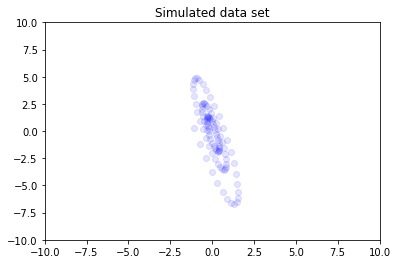

In [8]:
dim1 = 79
dim2 = 11
plt.scatter(x_train[:,dim1], x_train[:,dim2], color='blue', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.show()

## MXFusion Model Definition
Import MXFusion and MXNet modelling components

In [9]:
from mxfusion.models import Model
import mxnet.gluon.nn as nn
from mxfusion.components import Variable
from mxfusion.components.variables import PositiveTransformation
from mxfusion.components.functions.operators import broadcast_to

The primary data structure in MXFusion is the Model. Models hold ModelComponents, such as Variables, Distributions, and Functions which are the what define a probabilistic model. 

The model we'll be defining for PPCA is:

$p(z)$ ~ $N(\mathbf{\mu}, \mathbf{\Sigma)}$

$p(x | z,\theta)$ ~ $N(\mathbf{Wz} + \mu, \Psi)$

where:

$z \in \mathbb{R}^{N x K}, \mathbf{\mu} \in \mathbb{R}^K, \mathbf{\Sigma} \in \mathbb{R}^{NxKxK}, x \in \mathbb{R}^{NxD}$

$\Psi \in \mathbb{R}^{NxDxD}, \Psi = [\Psi_0, \dots, \Psi_N], \Psi_i = \sigma^2\mathbf{I}$

$z$ here is our latent variable of interest, $x$ is the observed data, and all other variables are parameters or constants of the model.

First we create an MXFusion Model object to build our PPCA model on. 

In [10]:
m = Model()

We attach ```Variable``` objects to our model to collect them in a centralized place. Internally, these are organized into a factor graph which is used during Inference. 

In [11]:
m.w = Variable(shape=(K,D), initial_value=mx.nd.array(np.random.randn(K,D)))

Because the mean of $x$'s distribution is composed of the dot product of $z$ and $W$, we need to create a dot product function. First we create a dot product function in MXNet and then wrap the function into MXFusion using the MXFusionGluonFunction class. ```m.dot``` can then be called like a normal python function and will apply to the variables it is called on.

In [12]:
dot = nn.HybridLambda(function='dot')
m.dot = mf.functions.MXFusionGluonFunction(dot, num_outputs=1, broadcastable=False)

Now we define ```m.z``` which has an identity matrix covariance ```cov``` and zero mean.

```m.z``` and ```sigma_2``` are then used to define ```m.x```.

Note that both ```sigma_2``` and ```cov``` will be added implicitly into the ```Model``` because they are inputs to ```m.x```.

In [13]:
cov = mx.nd.broadcast_to(mx.nd.expand_dims(mx.nd.array(np.eye(K,K)), 0),shape=(N,K,K))
m.z = mf.distributions.MultivariateNormal.define_variable(mean=mx.nd.zeros(shape=(N,K)), covariance=cov, shape=(N,K))
m.sigma_2 = Variable(shape=(1,), transformation=PositiveTransformation())
m.x = mf.distributions.Normal.define_variable(mean=m.dot(m.z, m.w), variance=broadcast_to(m.sigma_2, (N,D)), shape=(N,D))

## Posterior Definition

Now that we have our model, we need to define a posterior with parameters for the inference algorithm to optimize. When constructing a Posterior, we pass in the Model it is defined over and ModelComponent's from the original Model are accessible and visible in the Posterior.

The covariance matrix must continue to be positive definite throughout the optimization process in order to succeed in the Cholesky decomposition when drawing samples or computing the log pdf of ```q.z```. To satisfy this, we pass the covariance matrix parameters through a Gluon function that forces it into a Symmetric matrix for which suitable initialization values should maintain positive definite-ness throughout the optimization procedure. 

In [14]:
from mxfusion.inference import BatchInferenceLoop, GradBasedInference, GeneralizedVariationalInference, StochasticVariationalInference, RenyiAlpha, GammaLoss
class SymmetricMatrix(mx.gluon.HybridBlock):
    def hybrid_forward(self, F, x, *args, **kwargs):
        return F.sum((F.expand_dims(x, 3)*F.expand_dims(x, 2)), axis=-3)

While this model has an analytical solution, we will run Variational Inference to find the posterior to demonstrate inference in a setting where the answer is known. 

We place a multivariate normal prior over $z$ because that is $z$'s prior in the model and we don't need to approximate anything in this case. Because the form we're optimizing over is the true model, the optimization is convex and will always converge to the same answer given by classical PCA given enough iterations.


In [15]:
q = mf.models.Posterior(m)
sym = mf.components.functions.MXFusionGluonFunction(SymmetricMatrix(), num_outputs=1, broadcastable=False)
cov = Variable(shape=(N,K,K), initial_value=mx.nd.broadcast_to(mx.nd.expand_dims(mx.nd.array(np.eye(K,K) * 1e-2), 0),shape=(N,K,K)))
q.post_cov = sym(cov)
q.post_mean = Variable(shape=(N,K), initial_value=mx.nd.array(np.random.randn(N,K)))
q.z.set_prior(mf.distributions.MultivariateNormal(mean=q.post_mean, covariance=q.post_cov))

We now take our posterior and model, along with an observation pattern (in our case only ```m.x``` is observed) and create an inference algorithm. This inference algorithm is combined with a gradient loop to create the Inference method ```infr```.

In [16]:
observed = [m.x]
loss_function = GammaLoss(2.)
divergence = RenyiAlpha(3.)

alg = GeneralizedVariationalInference(num_samples=3, model=m, posterior=q, observed=observed,
                                      prior_vars=None, likelihood_vars=[m.z, m.x],
                                      divergence=divergence, loss_function=loss_function, data_size=len(x_train))
# alg = StochasticVariationalInference(num_samples=3, model=m, posterior=q, observed=observed)

infr = GradBasedInference(inference_algorithm=alg,  grad_loop=BatchInferenceLoop())

The inference method is then initialized with our training data and we run optimiziation for a while until convergence.

In [17]:
infr.initialize(x=mx.nd.array(x_train))

In [18]:
pdb

Automatic pdb calling has been turned ON


In [ ]:
infr.run(max_iter=1000, learning_rate=1e-2, x=mx.nd.array(x_train))

total_likelihood: 
[[-1277.4371  -1082.6447  -1002.2145  -1134.3063  -1003.9883  -1002.47314
   -990.05396 -1202.0746  -1057.0712  -1703.5632  -1022.7495  -1063.96
  -1049.139   -1151.3408  -1150.3212  -1086.7933  -1340.5487  -1066.0568
  -1133.6605  -1136.6396  -1058.3912  -1148.6455  -1105.5348  -1407.1499
  -1107.7625  -1472.6151  -1250.0223  -1125.21    -1282.2968  -1371.9141
  -1239.3905  -1196.9482  -1292.449   -1512.2828  -1218.9917  -1236.5883
  -1709.9939  -1248.1558  -1434.375   -1286.1304  -1509.6173  -1272.4373
  -1317.8037  -1425.4033  -1440.1798  -1402.4062  -1810.1855  -1522.1877
  -1533.301   -1459.1874  -1538.8479  -1472.596   -1542.9154  -1500.9316
  -1526.8823  -1696.9507  -1960.3506  -1722.5332  -1707.3888  -1645.7952
  -1750.0686  -1836.102   -1957.8096  -1973.3069  -2016.5205  -1946.5869
  -1952.8123  -2165.222   -1947.7173  -1934.1426  -2017.4502  -2053.6057
  -1937.4556  -2151.9966  -2143.4192  -2158.6677  -2562.7324  -2551.9924
  -2697.9949  -2658.3728  -2903.3

TypeError: compute_loss() takes 3 positional arguments but 4 were given

> /Users/erimeiss/workspace/mxfusion/mxfusion/inference/gvi.py(72)compute()
     70         print("total_posterior_loss: {}".format(total_posterior_loss))
     71 
---> 72         logL_bar = self.loss_function.compute_loss(total_likelihood, log_n, log_S)
     73 
     74         # Step 2: Divergence. Do inside self.divergence.



In [ ]:
m.x.factor.log_pdf_impl(mean=mx.nd.array([1,2]), variance=mx.nd.array([1,2]), random_variable=mx.nd.array([1,2]))

Once training completes, we retrieve the posterior mean (our trained representation for $\mathbf{Wz} + \mu$) from the inference method and plot it. 
As shown, the plot recovers (up to rotation) the original 2D data quite well.

In [ ]:
post_z_mean = infr.params[q.z.factor.mean].asnumpy()

In [ ]:
type(mx.nd.array([1]))

In [ ]:
plt.plot(post_z_mean[:,0], post_z_mean[:,1],'.')